Replace with an option to import a specific dataset

In [1]:
import pickle
with open('2016_1halfm.pickle', 'rb') as f:
    df = pickle.load(f)
df[:3]

,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,edited,gilded,id,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id,ups
0,ro910918,growlithe charmeleon fletchinder fire,"Ro 2251-8509-3964 [Fire:Growlithe,Charmeleon,F...",added!,0,1472688000,None,False,0,d74qmxr,t3_50jcsd,t1_d74p1xf,1475215923,1,False,friendsafari,t5_2yt52,1
1,[deleted],None,None,[removed],0,1472688000,None,False,0,d74qmxs,t3_500gn9,t1_d74qjy7,1475215923,1,False,pcgaming,t5_2qhfg,1
2,Heruza,None,None,TIFU potato,0,1472688000,None,False,0,d74qmxt,t3_5043zj,t3_5043zj,1475215923,2,False,default,t5_2to41,2


In [2]:
defaults = ['announcements', 'Art', 'AskReddit', 'askscience', 'aww', 'blog', 'books', 'creepy', 'dataisbeautiful', 'DIY', 'Documentaries', 'EarthPorn', 'explainlikeimfive', 'food', 'funny', 'Futurology', 'gadgets', 'gaming', 'GetMotivated', 'gifs', 'history', 'IAmA', 'InternetIsBeautiful', 'Jokes', 'LifeProTips', 'listentothis', 'mildlyinteresting', 'movies', 'Music', 'news', 'nosleep', 'nottheonion', 'OldSchoolCool', 'personalfinance', 'philosophy', 'photoshopbattles', 'pics', 'science', 'Showerthoughts', 'space', 'sports', 'television', 'tifu', 'todayilearned', 'UpliftingNews', 'videos', 'worldnews',]
use_default = True #True = Set values as default instead of orig sub name 
df['subreddit'] = df['subreddit'].apply(lambda ele: 'default' if ele in defaults and use_default else ele)
data_sub = df.groupby(['subreddit'])['author'].apply(list)
subs = df.groupby(by='subreddit')['id'].count().sort_values(ascending=False)[:300].index.values

In [3]:
import itertools as it
sub_conn = []
threshold = 40 #For 1m dataset 30 is best, 25 for more granularity, 35 for less
for pair in it.combinations(subs[1:250], 2):
    common_elem = list(set(data_sub[pair[0]]).intersection(set(data_sub[pair[1]])))
    if len(common_elem) > threshold:
        sub_conn.append([pair[0], pair[1], len(common_elem)])
sub_conn[:5]

[['politics', 'The_Donald', 422],
 ['politics', 'wow', 50],
 ['politics', 'Overwatch', 47],
 ['politics', 'pcmasterrace', 48],
 ['politics', 'nfl', 130]]

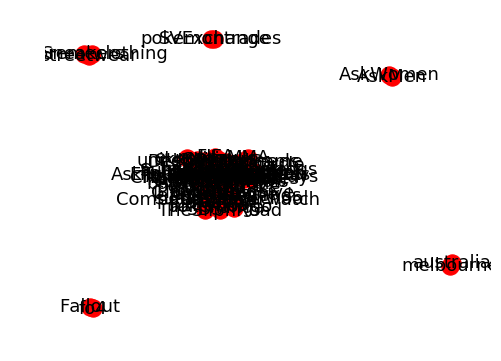

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

g = nx.Graph()
g.add_weighted_edges_from(sub_conn)

fig, axs = plt.subplots(figsize=(8, 6))
edge_wts = [ele[2] for ele in sub_conn]
pos = nx.spring_layout(g)
nx.draw(g, pos = pos, ax=axs, edge_color=edge_wts, font_size=18, with_labels=True, \
              edge_cmap= plt.get_cmap('bwr'), edge_vmin=1, edge_vmax=160)

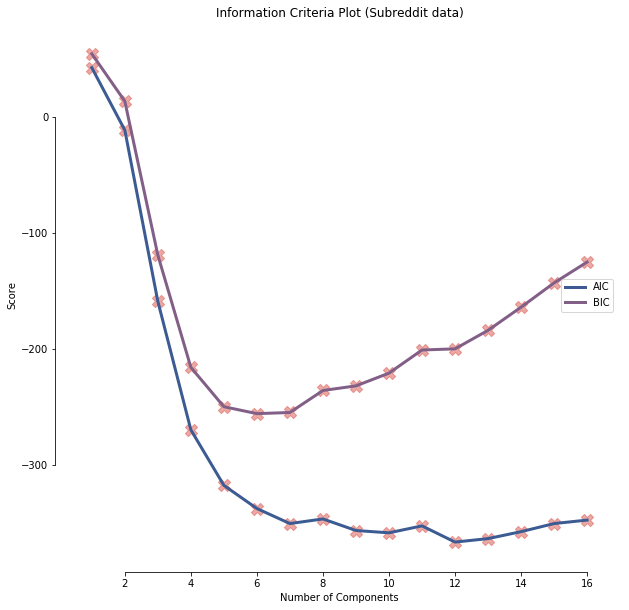

In [5]:
import seaborn as sns
from sklearn.mixture import GaussianMixture
import numpy as np

n_components = np.arange(1, 17)
aics = np.zeros_like(n_components)
bics = np.zeros_like(n_components)
loc = np.array(list(pos.values()))

for idx, nc in enumerate(n_components):
    # We build our model for nc components
    model = GaussianMixture(n_components=nc, covariance_type='full', 
                            n_init=10, random_state=23)
    model.fit(loc)
    aics[idx] = model.aic(loc)
    bics[idx] = model.bic(loc)  
fig, ax = plt.subplots(figsize=(10, 10))

# Show AIC points an curve
ax.scatter(n_components, aics, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_components, aics, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'], label='AIC')

# Show BIC points an curve
ax.scatter(n_components, bics, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_components, bics, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['dusty purple'], label='BIC')

# Add information
ax.legend(loc=7)

# Decorate Plot
ax.set(title='Information Criteria Plot (Subreddit data)', 
       xlabel='Number of Components', 
       ylabel='Score')
sns.despine(offset=5, trim=True)

In [6]:
import pandas as pd
xloc, yloc = zip(*pos.values())
names = list(pos.keys())
sub_size = data_sub.apply(len).to_dict()
size= [np.log2(sub_size[ele])*4 for ele in names]

In [7]:
'''
xloc, yloc = list(xloc), list(yloc)
for i, x in enumerate(xloc):
    if x > 0 and abs(yloc[i]) < .25:
        xloc[i] = (x-.1)*2
        yloc[i]*= 4
'''
print('this readjusts the positions so it aint all so spread out')

this readjusts the positions so it aint all so spread out


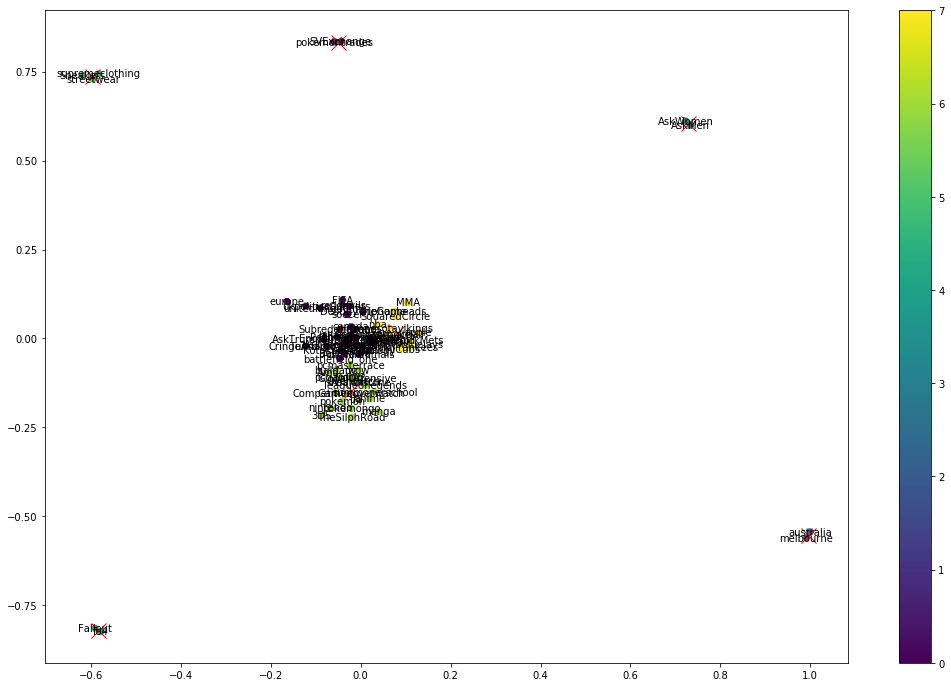

In [8]:
gmm = GaussianMixture(n_components=8, covariance_type='full').fit(loc)

# Obtain the predictions for clusters
y_pred = gmm.predict(loc)

#plot the data
fig, axs = plt.subplots(figsize=(18, 12))
cen_x, cen_y = zip(*gmm.means_)
sc = axs.scatter(xloc, yloc, c=y_pred, s=size, cmap='viridis', marker='H')
texts = [plt.text(xloc[i], yloc[i], names[i], ha='center', va='center') for i in range(len(xloc))]
axs.plot(cen_x, cen_y, 'rx', linestyle='', markersize=15)
plt.colorbar(sc)

In [9]:
cent_dist = [x[0]**2 + x[1]**2 for x in gmm.means_]
center_clusters = list(np.argpartition(cent_dist, 3)[:3])
gmm.means_, center_clusters

(array([[-0.03488233,  0.0099671 ],
        [-0.05158217,  0.83379657],
        [ 0.99554141, -0.55178752],
        [ 0.72821903,  0.60473252],
        [-0.58419145, -0.81886215],
        [-0.59846982,  0.73790294],
        [-0.02255341, -0.14482691],
        [ 0.0804481 ,  0.01722005]]), [0, 7, 6])

In [10]:
graph_data = pd.DataFrame([xloc, yloc, y_pred, size, names]).T
graph_data.columns = ['xloc', 'yloc', 'pred', 'size', 'name']
graph_data = graph_data[graph_data['pred'].isin(center_clusters)]

graph_data[:5]

,xloc,yloc,pred,size,name
0,-0.0110088,-0.0165949,0,59.5961,politics
1,-0.0311395,-0.0177705,0,56.5194,The_Donald
2,-0.00457324,-0.08954,6,54.9579,wow
3,-0.0163889,-0.119561,6,54.2006,Overwatch
4,-0.0235844,-0.075355,6,52.9482,pcmasterrace


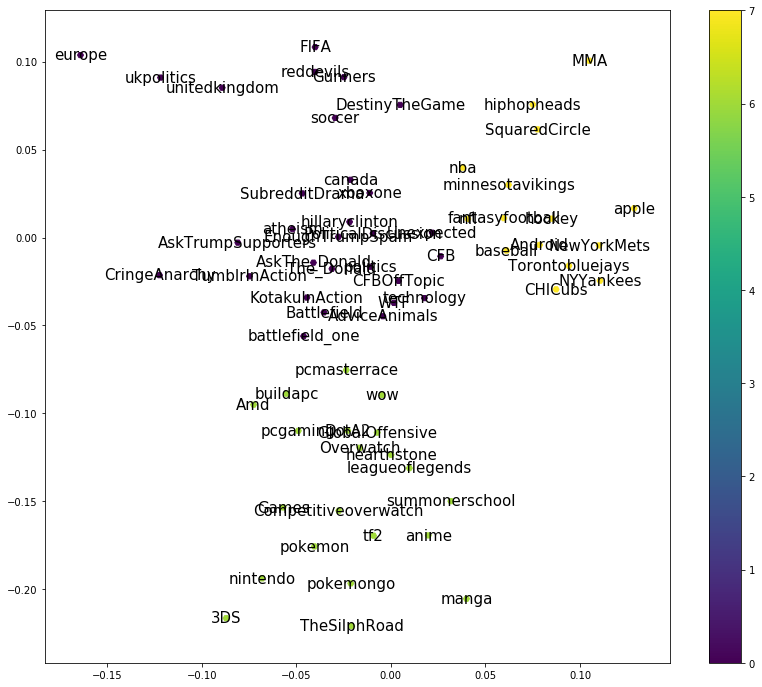

In [11]:
fig, axs = plt.subplots(figsize=(14, 12))
sc = axs.scatter(graph_data['xloc'], graph_data['yloc'], c=graph_data['pred'], cmap='viridis', marker='H')
texts = [plt.text(graph_data['xloc'].values[i], graph_data['yloc'].values[i], graph_data['name'].values[i], ha='center', va='center', fontsize=15) for i in range(len(graph_data))]
plt.colorbar(sc)

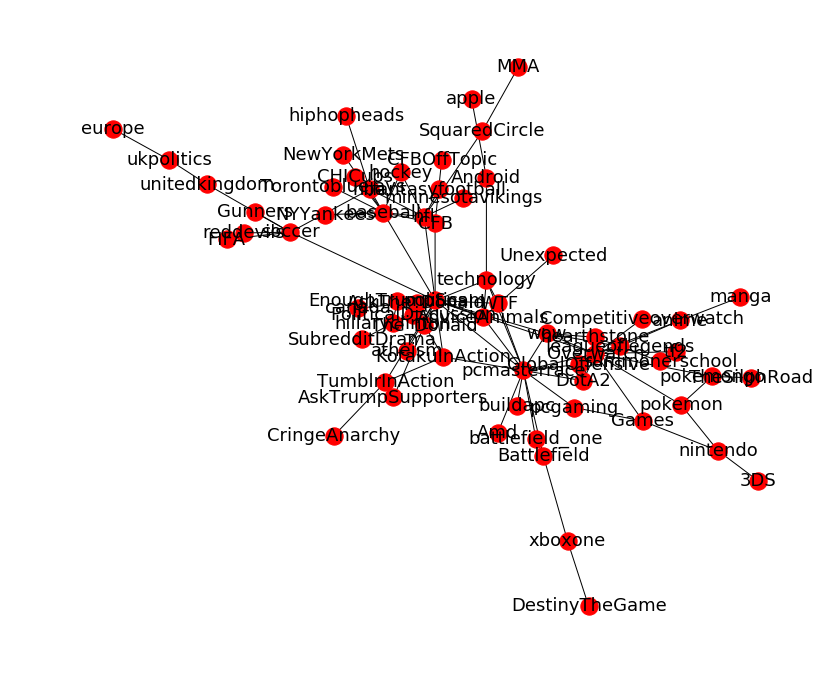

In [12]:
use = graph_data['name'].values
g = nx.Graph()
sub_conn2 = [ele for ele in sub_conn if ele[0] in use and ele[1] in use]
g.add_weighted_edges_from(sub_conn2)

fig, axs = plt.subplots(figsize=(14, 12))
edge_wts = [ele[2] for ele in sub_conn2]
nx.draw_spring(g, ax=axs, font_size=18, with_labels=True, \
              )

In [13]:
center_2016 = graph_data['name'].values
center_comments = df[df['subreddit'].isin(center_2016)]['body'].values
print(center_comments[:3], len(center_comments))

['[removed]'
 "And the same city in which he might live in once he's done with his playing career?"
 'You really do have to see how world quests work to understand fully. Each zone has their own rep associated to the quests, I.e. farondis for azsuna. So MOST of the world quests in Azsuna will give you farondis rep.'] 320475


In [18]:
with open('center_comments.pickle', 'wb') as f:
    pickle.dump(center_comments, f)

C:\Users\Shriyak\Anaconda3\lib\site-packages\matplotlib\contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


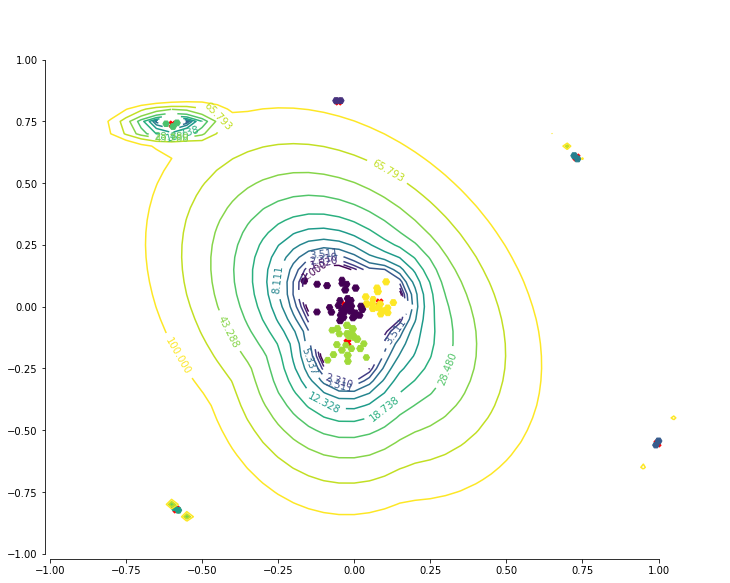

In [17]:
from matplotlib.colors import LogNorm

# Generate mesh grid of points
grid = np.arange(-1, 1.25, 0.05)
xg, yg = np.meshgrid(grid, grid)
grid_data = np.array([xg.ravel(), yg.ravel()]).T

# Compute sample scores for mesh.
z = -1.0 * gmm.score_samples(grid_data).reshape(xg.shape)

# Now make the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Show data
ax.scatter(cen_x, cen_y, 
           s=50, c='r', marker='X', label='Cluster Centers')
ax.scatter(xloc, yloc, c=y_pred, s=size, cmap='viridis', marker='H')

# Overplot contours & label them
ct = ax.contour(xg, yg, z, norm=LogNorm(vmin=1.0, vmax=100.),
           levels=np.logspace(0, 2, 12))
ax.clabel(ct, inline=True, fontsize=10)

# Clean the plot
sns.despine(offset=5, trim=True, ax=ax)